In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
fold_1 = pd.read_csv('../andreas/fold_1.csv', index_col = 0)
fold_2 = pd.read_csv('../andreas/fold_2.csv', index_col = 0)
fold_3 = pd.read_csv('../andreas/fold_3.csv', index_col = 0)
fold_4 = pd.read_csv('../andreas/fold_4.csv', index_col = 0)
fold_5 = pd.read_csv('../andreas/fold_5.csv', index_col = 0)
folds = [fold_1, fold_2, fold_3, fold_4, fold_5]

In [127]:
train = pd.read_csv("../data/data_train.csv")

(array([ 43508.,      0.,  99180.,      0.,      0., 274327.,      0.,
        324700.,      0., 435237.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

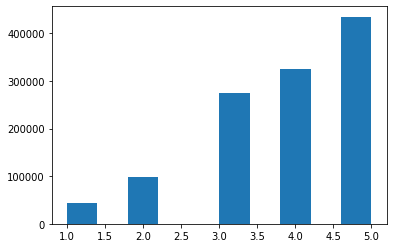

In [10]:
plt.hist(train['Prediction'])

In [18]:
np.mean(train['Prediction']), np.var(train['Prediction'])

(3.8572805008190647, 1.252287973378689)

Implicit Preference:
pLSA: (u, y) generated independently 
$$P(user, item; \theta) = \sum_{i = 1}^{k}P(u, y, z_i) = \sum_{i = 1}^{k}P(y | z_i)P(z|u)P(u)$$
personalized
$$P(item|user;\theta)=\sum_{i=1}^{k} P(y|z)P(z|u)$$
- k = 1, "non-personalized"
Generalization to explicit:
$$P(rating|item,user)=\sum_{i=1}^{k} P(rating|item, z)P(z|user)$$
- Parametric form
    - Multinomial (binary)


In [34]:
A = np.ones((3,1, 3))
fold_1.iloc[1]['Prediction']

5

In [93]:
test = np.array([[5, 1, 3], [4, 4, 4], [3, 5, 2]])
ratings = pd.DataFrame(data=[[0, 2, 3], [2, 2, 2], [1, 1, 4], [0,  0, 5], [2, 0, 3]], columns=['row', 'col', 'Prediction'])
ratings

,row,col,Prediction
0,0,2,3
1,2,2,2
2,1,1,4
3,0,0,5
4,2,0,3


In [95]:
idx = ratings[ratings['row']==0]['col']
idx

0    2
3    0
Name: col, dtype: int64

In [41]:
pz, mu = gaussian_pLSA(target, 10000, 1000, 20, 5)

Iteration 0:
Start E-step...
E-step finished using time 200.1708002090454
Start M-step...
M-step finished using time 7.4005889892578125
Iteration 1:
Start E-step...
E-step finished using time 197.5393409729004
Start M-step...
M-step finished using time 6.563522100448608
Iteration 2:
Start E-step...
E-step finished using time 196.0863540172577
Start M-step...
M-step finished using time 6.545164108276367
Iteration 3:
Start E-step...
E-step finished using time 196.79258799552917
Start M-step...
M-step finished using time 6.546828031539917
Iteration 4:
Start E-step...
E-step finished using time 194.66397285461426
Start M-step...
M-step finished using time 6.518856763839722


In [55]:
target = pd.concat([fold_2, fold_3, fold_4, fold_5])
ridx = fold_1.loc[:,'row']
cidx = fold_1.loc[:, 'col']

In [54]:
mu[0]

array([3.41048795, 3.13499629, 3.28250101, 3.41920533, 3.36675927,
       3.13976446, 3.31621589, 3.41263474, 3.40958554, 3.28039173,
       3.49333175, 3.69039204, 3.68830952, 3.42905236, 3.00712185,
       3.39218403, 3.60804103, 3.39330882, 3.36524358, 3.36511231])

In [56]:
prediction = np.nan_to_num(pz)@np.nan_to_num(mu.T)
np.sqrt(np.mean(np.square(fold_1['Prediction']- prediction[ridx, cidx])))

1.0281296956852135

In [4]:
def rating_gaussian_model(rating, mean, var):
    return np.exp(-(rating-mean)**2/(2*var))/(np.sqrt(2*np.pi*var))

def df_to_mat(ratings, num_row, num_col):
    result = np.zeros((num_row, num_col))
    for i in range(num_row):
        colidx = ratings[ratings['row'] == i]['col']
        result[i, colidx] = ratings[ratings['row'] == i]['Prediction']
    return result


In [169]:

def gaussian_pLSA(ratings, num_users, num_items, num_hidden_states = 5, max_iter = 100):
    #initialization
    np.random.seed(0)
    p_z = np.random.rand(num_users, num_hidden_states) #P(z|u)
    p_z /= p_z.sum(1)[:,  np.newaxis]
    mu_iz  = np.zeros((num_items, num_hidden_states))  + np.mean(ratings['Prediction'])
    sigma2_iz = np.ones((num_items, num_hidden_states)) + np.var(ratings['Prediction'])
    p_z_given_uri = np.zeros((num_users, num_items, num_hidden_states))
    rating_mat = df_to_mat(ratings, num_users, num_items)
    # E-step
    for i in range(max_iter):
        print("Iteration {}:".format(i))
        print("Start E-step...")
        st = time.time()
        for r in range(ratings.shape[0]):
            user = ratings.iloc[r]['row']
            item = ratings.iloc[r]['col']
            rating = ratings.iloc[r]['Prediction']
            p_rating_item = rating_gaussian_model(rating, mu_iz[item], sigma2_iz[item])#all p(rating, item|z)
            denom = np.dot(p_rating_item, p_z[user]) #p(rating,  item|z)p(z|u)
            for z in range(num_hidden_states):
                nom = rating_gaussian_model(rating, mu_iz[item, z], sigma2_iz[item, z])*p_z[user, z]  
                p_z_given_uri[user, item, z] = nom/denom #p(z|user, rating, item;thetahat)
        print("E-step finished using time {}".format(time.time()-st))
        # M-step
        print("Start M-step...")
        st = time.time()
        for u in range(num_users): # update P(z|u)
            denom = np.sum(p_z_given_uri[u]) # sum_z sum_u P(z|u, v, y;hattheta)
            for z in range(num_hidden_states):
                p_z[u, z] = np.sum(p_z_given_uri[u][:, z])/denom # sum of P(z|user, rating, item; thetahat)
        for i in range(num_items):
            for z in range(num_hidden_states):           
                denom = np.sum(p_z_given_uri[:, i, z]) #sum_y  {(z|user, rating, item)}
                item_rating = rating_mat[:, i]
                mu_iz[i, z] = np.dot(p_z_given_uri[:, i, z], item_rating)/denom
                sigma2_iz[i, z] = np.dot(np.square(item_rating - mu_iz[i,z]), p_z_given_uri[:, i, z])/denom
        print("M-step finished using time {}".format(time.time()-st))
        print("="*20)
    return p_z, mu_iz
        


In [170]:
pz1, mu1 = gaussian_pLSA(ratings, 3, 3, 5, 1)

Iteration 0:
Start E-step...
E-step finished using time 0.0036199092864990234
Start M-step...
M-step finished using time 0.0014929771423339844


In [171]:
pz1, mu1

(array([[0.19356424, 0.25224431, 0.21259213, 0.19217803, 0.14942128],
        [0.19440831, 0.13170981, 0.26841564, 0.29005381, 0.11541244],
        [0.27439982, 0.18330691, 0.19687558, 0.32079767, 0.02462001]]),
 array([[3.82726113, 4.15827622, 4.03838289, 3.74926757, 4.71707848],
        [4.        , 4.        , 4.        , 4.        , 4.        ],
        [2.41363057, 2.57913811, 2.51919145, 2.37463379, 2.85853924]]))

In [173]:
pz2, mu2 = gaussian_pLSA(ratings, 3, 3, 5, 1)

Iteration 0:
Start E-step...
E-step finished using time 0.0020940303802490234
Start M-step...
M-step finished using time 0.0008440017700195312


In [174]:
pz2, mu2

(array([[0.19356424, 0.25224431, 0.21259213, 0.19217803, 0.14942128],
        [0.19440831, 0.13170981, 0.26841564, 0.29005381, 0.11541244],
        [0.27439982, 0.18330691, 0.19687558, 0.32079767, 0.02462001]]),
 array([[3.82726113, 4.15827622, 4.03838289, 3.74926757, 4.71707848],
        [4.        , 4.        , 4.        , 4.        , 4.        ],
        [2.41363057, 2.57913811, 2.51919145, 2.37463379, 2.85853924]]))

In [3]:
def gaussian_pLSA(ratings, num_users, num_items, num_hidden_states = 5, max_iter = 100):
    #initialization
    np.random.seed(0)
    p_z = np.random.rand(num_users, num_hidden_states) #P(z|u)
    p_z /= p_z.sum(1)[:,  np.newaxis]
    mu_iz  = np.zeros((num_items, num_hidden_states))  + np.mean(ratings['Prediction'])
    sigma2_iz = np.ones((num_items, num_hidden_states)) + np.var(ratings['Prediction'])
    p_z_given_uri = np.zeros((num_users, num_items, num_hidden_states))
    rating_mat = df_to_mat(ratings, num_users, num_items)
    # E-step
    for i in range(max_iter):
        print("Iteration {}:".format(i))
        print("Start E-step...")
        st = time.time()
        def helper(row):
            user = row[0]
            item = row[1]
            rating = row[2]
            p_rating_item = rating_gaussian_model(rating, mu_iz[item], sigma2_iz[item])#all p(rating, item|z)
            denom = np.dot(p_rating_item, p_z[user]) #p(rating,  item|z)p(z|u)
            for z in range(num_hidden_states):
                nom = rating_gaussian_model(rating, mu_iz[item, z], sigma2_iz[item, z])*p_z[user, z]  
                p_z_given_uri[user, item, z] = nom/denom #p(z|user, rating, item;thetahat)
        ratings.apply(helper, 1)
        print("E-step finished using time {}".format(time.time()-st))
        
            
        # M-step
        print("Start M-step...")
        st = time.time()
        for u in range(num_users): # update P(z|u)
            denom = np.sum(p_z_given_uri[u]) # sum_z sum_u P(z|u, v, y;hattheta)
            for z in range(num_hidden_states):
                p_z[u, z] = np.sum(p_z_given_uri[u][:, z])/denom # sum of P(z|user, rating, item; thetahat)
        for i in range(num_items):
            for z in range(num_hidden_states):           
                denom = np.sum(p_z_given_uri[:, i, z]) #sum_y  {(z|user, rating, item)}
                item_rating = rating_mat[:, i]
                mu_iz[i, z] = np.dot(p_z_given_uri[:, i, z], item_rating)/denom
                sigma2_iz[i, z] = np.dot(np.square(item_rating - mu_iz[i,z]), p_z_given_uri[:, i, z])/denom
        print("M-step finished using time {}".format(time.time()-st))
        print("="*20)
    return p_z, mu_iz

In [ ]:
Q = np.ones(())
Q = Q/np.sum(Q) 
cond_rating_item = 
cond_latent = 
neg_log_risk = -np.sum(np.log() + np.log())


In [16]:
from scipy.optimize import minimize

In [14]:
minimize(fun = , x0 = [0,0])
def loss(b, ratings, mu, lambda1):
    bu, bi = b[0], b[1]
    np.sum(np.square(ratings - mu - bu - bi)) + lambda1*

<module 'scipy.optimize.optimize' from '/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py'>

In [ ]:
def base_avg_model(data, lr, tol):
    global_avg_rating = np.mean(data['Prediction'])
    bu, bi = 0, 0
    while max_iter > 0:
        gradient_bu = sum of 2*(r - global_avg_rating - bu - bi)*(-1) + lambda1*(sum of 2*bu)
        gradient_bi = sum of 2*(r - global_avg_rating - bu - bi)*(-1) + lambda1*(sum of 2*bi)
        bu -= gradient_bu*lr
        bi -= gradient_bi*lr
        err = sum (r - global_avg_rating - bu - bi)**2 + lambda1*(sumbu**2  + sumbi**2)
        if err <= tol:
            break
        max_iter -= 1 
    pred_matrix = 
    return pred_matrix

In [ ]:
while max_iter > 0:
    for i, r in enumerate(ratings):
        err = r - r_pred[i]
        
        bu += gamma*(err - lambda4*bu)
        bi += gamma*(err - lambda4*bi)
        for j in userrated:
            wij += gamma*()
        for in :
            
        r_pred[i] = mu + bu + bi + #TODO# + #TODO#
    if 
    max_iter -= 1
    